In [1]:
%reload_ext autoreload
%autoreload 2

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
from sklearn.decomposition import PCA

import sys
sys.path.append('/home/yangz2/projects/bishop1995_notes/modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, MulticlassAccuracyCallback, BinaryAccuracyCallback

from trainer import Trainer

In [4]:
class NN(nn.Module):
    
    def __init__(self, num_classes, input_dim):
        super().__init__()

        self.num_classes = num_classes

        self.main = nn.Sequential(

            nn.Linear(input_dim, 500),
            nn.BatchNorm1d(500),  # maintain health gradient flow
            nn.ReLU(),

            nn.Linear(500, 500),
            nn.BatchNorm1d(500),  # maintain health gradient flow
            nn.ReLU(),

            nn.Linear(500, self.num_classes),  # maintain health gradient flow
            nn.ReLU(),

        )

    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1, self.num_classes)
    
def get_model(input_dim, num_classes):
    nn = NN(num_classes, input_dim)
    return nn, optim.Adam(nn.parameters(), lr=10)

In [5]:
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results'
GAME = 'kia'
MODEL = 'vae_gmm'

In [10]:
for num_components in tqdm_notebook([30, 40, 50]):
    
    with open(f'{RESULTS_DIR}/{GAME}_{MODEL}_generations/{GAME}_{MODEL}_{num_components}.json', 'r') as json_f:
        x = np.array(json.load(json_f))
        x = x.reshape(x.shape[0], 16, 16)
        encoding_len = len(np.unique(x))
        x = np.eye(encoding_len)[x]
        x = x.reshape(-1, encoding_len * 16 * 16)
    
    y = np.repeat(np.arange(num_components), 500)

    seed = np.random.randint(1000)
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    
    x_train, y_train = x[:300 * num_components], y[:300 * num_components]
    x_valid, y_valid = x[-200 * num_components:], y[-200 * num_components:]

    train_ds = TD(T(x_train), T(y_train))
    train_dl = DL(train_ds, batch_size=64, shuffle=True)

    valid_ds = TD(T(x_valid), T(y_valid))
    valid_dl = DL(valid_ds, batch_size=64, shuffle=False)
    
    model, opt = get_model(input_dim=x.shape[1], num_classes=num_components)
    loss = nn.CrossEntropyLoss()
    learn = Learner(train_dl, valid_dl, model, loss, opt)

    loss_cb = LossCallback()
    acc_cb = MulticlassAccuracyCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

    trainer = Trainer(learn=learn, cb_handler=cb_handler)

    trainer.set_lr(5e-4)
    trainer.train(10)
    
    output = model(valid_ds.tensors[0].float())
    ypred = output.detach().numpy().argmax(axis=1)
    conf_mat = confusion_matrix(valid_ds.tensors[1].long().numpy(), ypred)
    
    with open(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots/confmat_{num_components}.json', 'w+') as json_f:
        json.dump(conf_mat.tolist(), json_f)

In [13]:
confmats = []
for fname in sorted(
    [fn for fn in os.listdir(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots') if fn[0] != '.'], 
    key=lambda fn : int(fn.split('.')[0].split('_')[1])
):  
    with open(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots/{fname}', 'r') as json_f:
        confmats.append(np.array(json.load(json_f)))

In [14]:
len(confmats)

10

In [15]:
num_components_s = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]
len(num_components_s)

10

In [23]:
accs_to_search = [70, 80, 90]
accs_s = [[] for k in accs_to_search]
for confmat in confmats:
    confmat = confmat / confmat.sum(axis=1).reshape(-1, 1)
    diag = confmat * np.eye(confmat.shape[0])
    for i, acc in enumerate(accs_to_search):
        accs_s[i].append(np.sum(diag[diag != 0] >= (acc / 100)))

In [24]:
np.array(accs_s).shape

(3, 10)

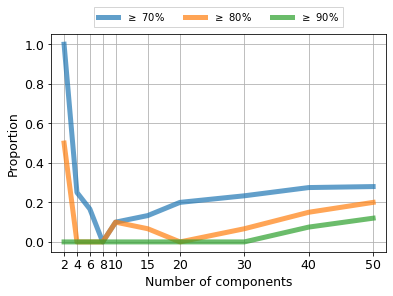

In [25]:
for i, (acc, accs) in enumerate(zip(accs_to_search, accs_s)):
    plt.plot(num_components_s, np.array(accs) / np.array(num_components_s), linewidth=5, alpha=0.7, label=f'$\geq$ {acc}%')
plt.xlabel('Number of components', fontsize=12.5); plt.ylabel('Proportion', fontsize=12.5)
plt.xticks(num_components_s, fontsize=12.5); plt.yticks(fontsize=12.5)
plt.xlim(0, 52)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=False, shadow=False)
plt.savefig(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots/{GAME}_{MODEL}_disentanglement.png', dpi=100)